In [23]:
from google.colab import drive
drive.mount('//content//drive')

Drive already mounted at //content//drive; to attempt to forcibly remount, call drive.mount("//content//drive", force_remount=True).


In [34]:
!pip install --upgrade tensorflow

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras import Model

from tensorflow.keras.layers import (
    Input, Embedding, LSTM, GRU, SimpleRNN,
    Dense, Dropout, Flatten, BatchNormalization,
    GlobalAveragePooling2D, LeakyReLU
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dropout, BatchNormalization, Attention, Add, Dense, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/data.csv")

df.head(6)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive


In [ ]:
df.columns

Index(['Sentence', 'Sentiment'], dtype='object')

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

<ipython-input-9-2ce3b391a5b5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='Set2')


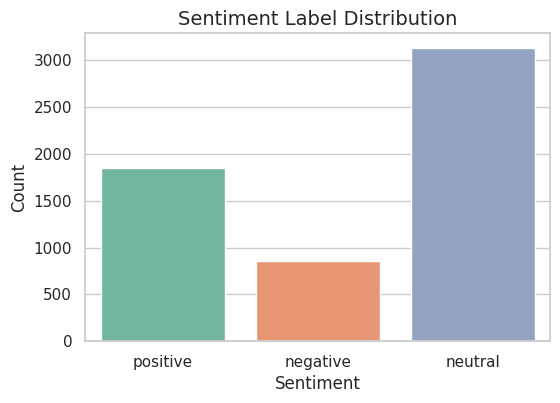

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(x='Sentiment', data=df, palette='Set2')
plt.title("Sentiment Label Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

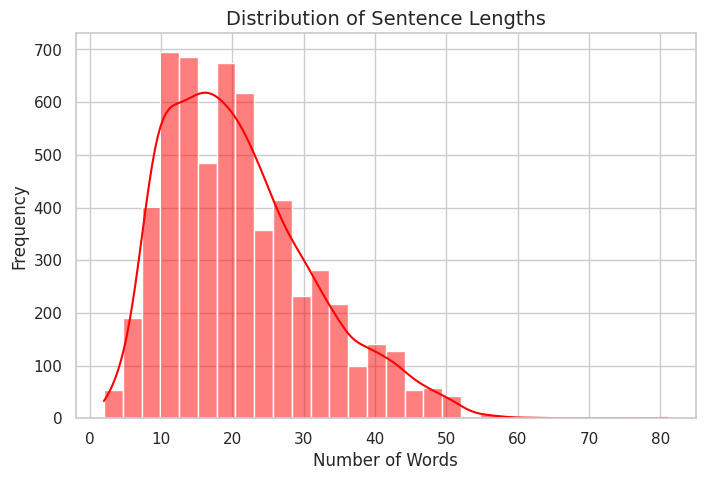

In [ ]:
df['sentence_length'] = df['Sentence'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
plt.figure(figsize=(8, 5))
sns.histplot(df['sentence_length'], bins=30, kde=True, color='red')
plt.title("Distribution of Sentence Lengths", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

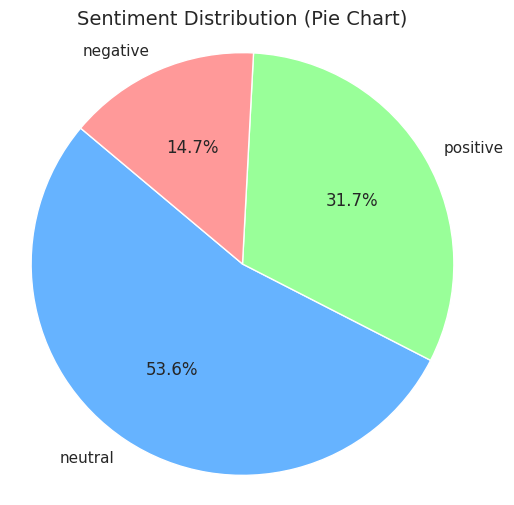

In [ ]:
sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
        startangle=140, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title("Sentiment Distribution (Pie Chart)", fontsize=14)
plt.axis('equal')
plt.show()

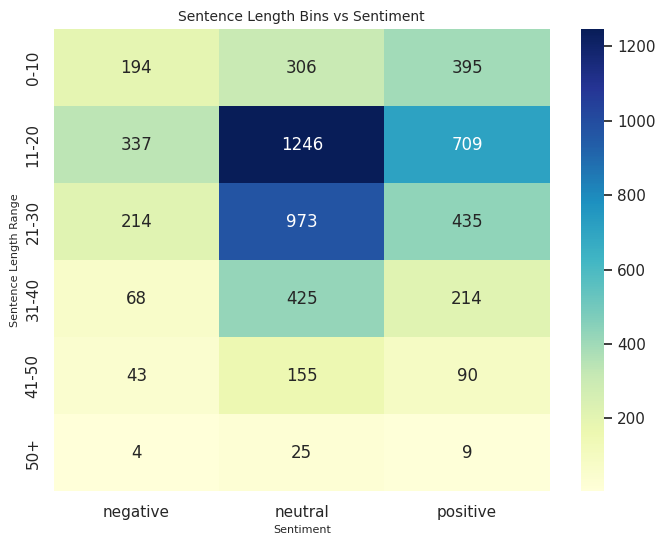

In [ ]:
df['length_bin'] = pd.cut(df['sentence_length'], bins=[0,10,20,30,40,50,100],
                          labels=['0-10','11-20','21-30','31-40','41-50','50+'])

heat_data = pd.crosstab(df['length_bin'], df['Sentiment'])
plt.figure(figsize=(8,6))
sns.heatmap(heat_data, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Sentence Length Bins vs Sentiment", fontsize=10)
plt.xlabel("Sentiment", fontsize=8)
plt.ylabel("Sentence Length Range", fontsize=8)
plt.show()

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'])
sequences = tokenizer.texts_to_sequences(df['Sentence'])

In [24]:
max_len = max(df['sentence_length'])
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = to_categorical(df['label'])

In [26]:
df.head(6)

,Sentence,Sentiment,label,sentence_length,length_bin
0,The GeoSolutions technology will leverage Bene...,positive,2,32,31-40
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,0,11,11-20
2,"For the last quarter of 2010 , Componenta 's n...",positive,2,39,31-40
3,According to the Finnish-Russian Chamber of Co...,neutral,1,20,11-20
4,The Swedish buyout firm has sold its remaining...,neutral,1,23,21-30
5,$SPY wouldn't be surprised to see a green close,positive,2,9,0-10


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.3, random_state=42)

In [28]:
def lstm_block(x, units, return_sequences = False , dp = 0.4):
    residual = x
    x = Bidirectional(LSTM(units,return_sequences=True , kernel_regularizer=l2(0.001)))(x)
    x = Dropout(dp)(x)
    x = BatchNormalization()(x)

    attentiob = Attention()([x,x])
    x = Add()([x,attentiob])

    if residual.shape[-1] != x.shape[-1]:
        residual = Dense(x.shape[-1])(residual)
    x = Add()([x,residual])

    if not return_sequences:
        x = GlobalAveragePooling1D()(x)

    return x

In [29]:
def model_lstm(input_shape):
    inputs = Input(shape = input_shape)

    x = lstm_block(inputs, 1024, return_sequences=True)
    x = lstm_block(x, 512, return_sequences=True)
    x = lstm_block(x, 256, return_sequences=True)
    x = lstm_block(x, 128, return_sequences=True)
    x = lstm_block(x, 64, return_sequences=False)

    for units , rate in [(512,0.4) , (256,0.4) ,(128,0.4) , (128,0.3) ,(64,0.3)]:
        x = Dense(units)(x)
        x = LeakyReLU()(x)
        x = Dropout(rate)(x)

    outputs= Dense(3,activation="softmax")(x)

    model = Model(inputs , outputs)
    model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [30]:
model = model_lstm((max_len,1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 81, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 81, 2048)  │  8,404,992 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 81, 2048)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 81, 2048)  │      8,192 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 81, 2048)  │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 81, 2048)  │          0 │ batch_normalizat… │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 81, 2048)  │      4,096 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 81, 2048)  │          0 │ add[0][0],        │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 81, 1024)  │ 10,489,856 │ add_1[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 81, 1024)  │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 81, 1024)  │      4,096 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 81, 1024)  │          0 │ batch_normalizat… │
│ (Attention)         │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 81, 1024)  │          0 │ batch_normalizat… │
│                     │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 81, 1024)  │  2,098,176 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 81, 1024)  │          0 │ add_2[0][0],      │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 81, 512)   │  2,623,488 │ add_3[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 81, 512)   │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 81, 512)   │      2,048 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 25,401,475 (96.90 MB)

 Trainable params: 25,393,539 (96.87 MB)

 Non-trainable params: 7,936 (31.00 KB)

55/55 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step


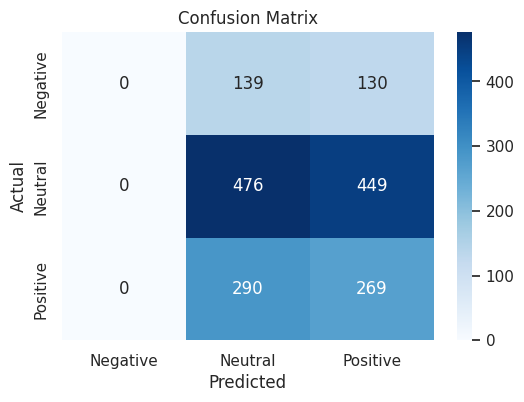

In [32]:
y_test = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       269
     Neutral       0.53      0.51      0.52       925
    Positive       0.32      0.48      0.38       559

    accuracy                           0.42      1753
   macro avg       0.28      0.33      0.30      1753
weighted avg       0.38      0.42      0.40      1753



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
